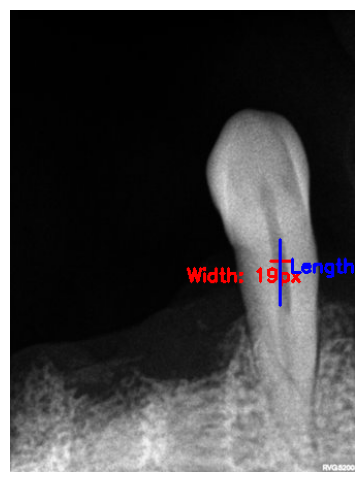

In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Configuration
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 50

def load_and_preprocess(image_path, mask_path):
    """Load and preprocess image-mask pair"""
    # Load images
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    
    # Resize and normalize
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    
    # Convert mask to measurement channels
    mask = extract_measurement_lines(mask)
    
    return image[..., np.newaxis]/255.0, mask/255.0

def extract_measurement_lines(mask_image):
    """Convert RGB measurement image to 3-channel binary mask"""
    # Define color ranges for measurement lines (BGR format)
    red_range = ((0, 0, 100), (100, 100, 255))
    green_range = ((0, 100, 0), (100, 255, 100))
    blue_range = ((100, 0, 0), (255, 100, 100))

    # Create individual channels
    red_channel = cv2.inRange(mask_image, *red_range)
    green_channel = cv2.inRange(mask_image, *green_range)
    blue_channel = cv2.inRange(mask_image, *blue_range)

    return np.stack([red_channel, green_channel, blue_channel], axis=-1)

def build_measurement_unet():
    """Build U-Net model for measurement line prediction"""
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    
    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)
    
    # Bridge
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.UpSampling2D(2)(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    
    u2 = layers.UpSampling2D(2)(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    
    # Output - 3 channels for measurement lines
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(c5)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

def train_model(train_dir, val_dir):
    """Train the measurement prediction model"""
    # Get image pairs
    train_images = sorted([f for f in os.listdir(train_dir) if f.startswith('image_')])
    train_masks = sorted([f for f in os.listdir(train_dir) if f.startswith('mask_')])
    
    # Create datasets
    X_train = []
    y_train = []
    for img_path, mask_path in zip(train_images, train_masks):
        x, y = load_and_preprocess(os.path.join(train_dir, img_path),
                                 os.path.join(train_dir, mask_path))
        X_train.append(x)
        y_train.append(y)
    
    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # Build and train model
    model = build_measurement_unet()
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)
    
    return model

def predict_measurements(model, image_path):
    """Generate measurement lines for new images"""
    # Load and preprocess
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    orig_size = image.shape
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))[..., np.newaxis]/255.0
    
    # Predict
    pred = model.predict(np.array([image]))[0]
    
    # Post-process predictions
    lines = []
    for i in range(3):  # For each measurement line
        channel = pred[..., i]
        thresholded = (channel > 0.5).astype(np.uint8)
        lines.append(cv2.resize(thresholded, orig_size[::-1]))
    
    return lines

def draw_measurements(image_path, lines):
    """Draw predicted measurement lines on original image"""
    # Load original image
    image = cv2.imread(image_path)
    
    # Define colors for lines
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]  # BGR format
    
    # Draw each line
    for line_mask, color in zip(lines, colors):
        contours, _ = cv2.findContours(line_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            cv2.drawContours(image, [cnt], -1, color, 2)
    
    return image

# Usage Example
# 1. Organize your data:
#    - training_dir/
#        - image_001.png (original X-ray)
#        - mask_001.png (corresponding measured image)
#        - image_002.png
#        - mask_002.png

# 2. Train the model:
model = train_model('training_dir', 'validation_dir')

# 3. Use on new images:
lines = predict_measurements(model, 'new_xray.jpg')
result_image = draw_measurements('new_xray.jpg', lines)
cv2.imwrite('measured_result.jpg', result_image)
